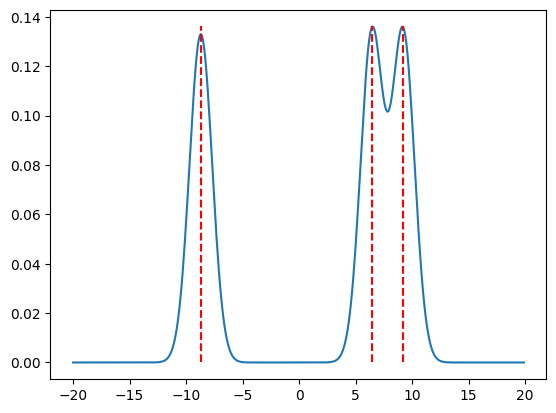

In [1]:

from src_bis.gmm import FGMM 
import torch 
import numpy as np 
gmm = FGMM(d=1)


from matplotlib import pyplot as plt
x = torch.arange(-20,20,0.1)
y = gmm.prob(x[:,None,None])
plt.plot(x,y )
plt.vlines(gmm.means, ymin = 0, ymax = y.max(), colors = "r", ls = "--")

Generating noise
[[[ 0.52390263  0.70570393]
  [ 0.70570393  2.        ]]

 [[ 2.          0.9516578 ]
  [ 0.9516578   0.52689467]]

 [[ 2.         -0.50821637]
  [-0.50821637  0.32143529]]]


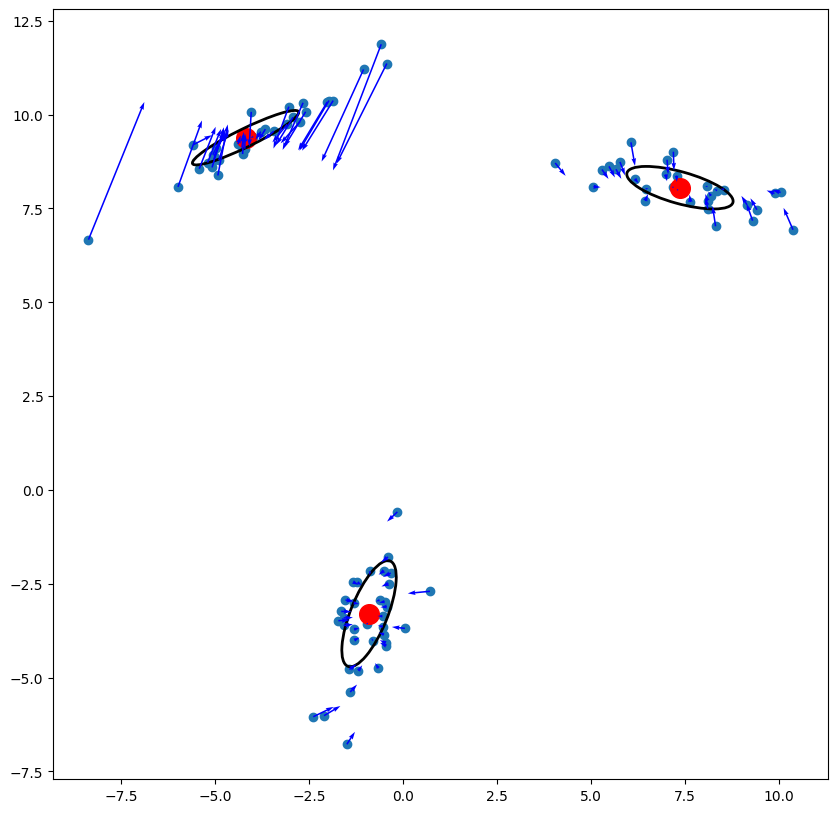

/Users/margueritetalamon/Desktop/crest/code/git/src_bis/gmm.py:143: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator


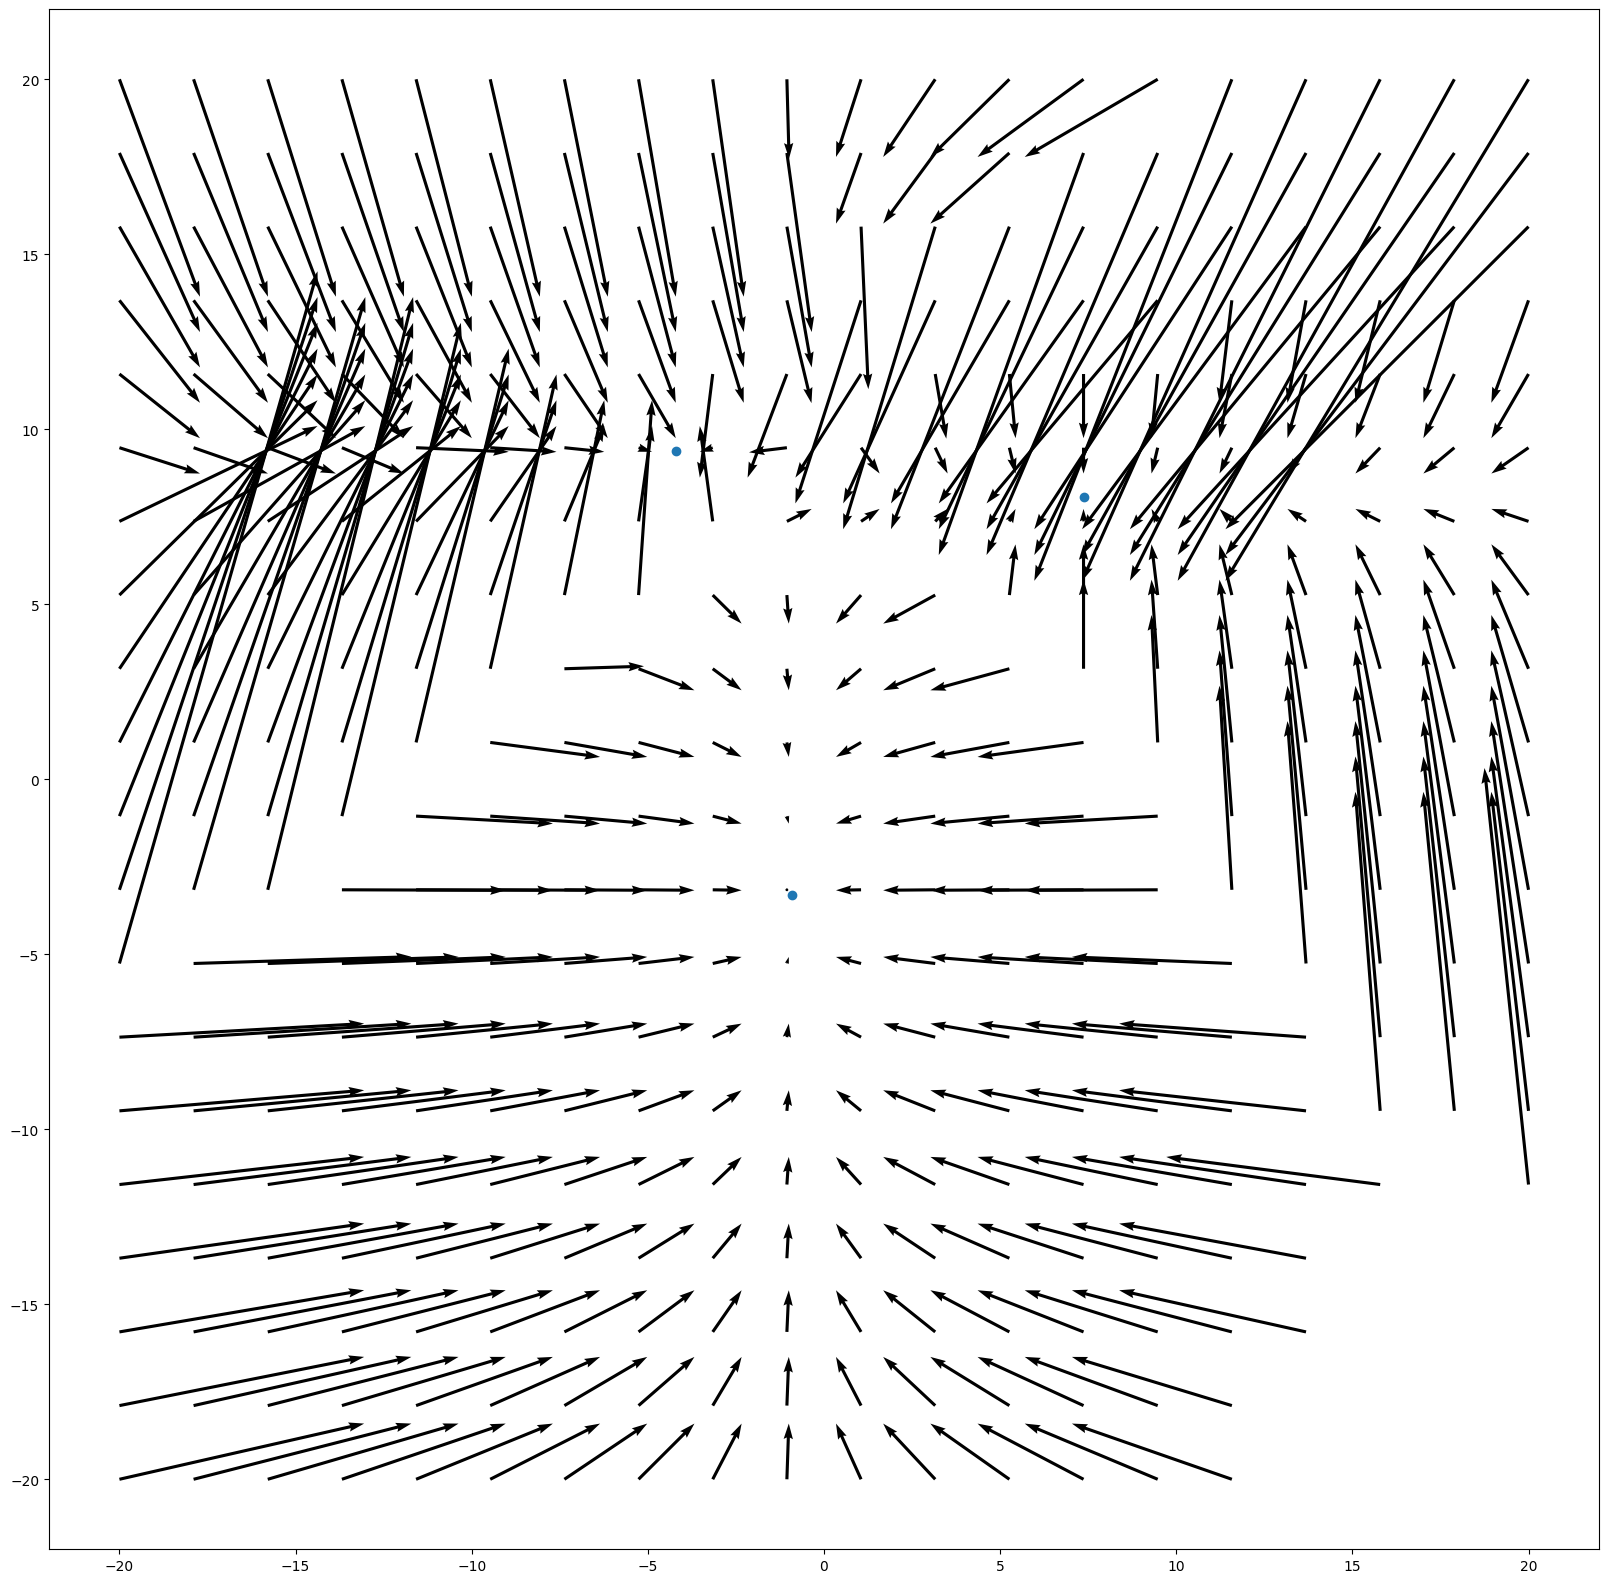

In [2]:

from matplotlib.patches import Ellipse


B= 100
vgmm = FGMM(d = 2, scale = 2, n_components = 3, s = 10)

samples = vgmm.sample(100)
plt.figure(figsize=(10,10))
# plt.ylim((-15,15))
# plt.xlim((-15,15))
plt.scatter(samples[:,0],samples[:,1])

plt.scatter(vgmm.means[:,0],vgmm.means[:,1], s = 200, color = "r")

for i in range(vgmm.n_components):
    cov = vgmm.covariances[i]  # 2x2 covariance matrix for the i-th component
    mean = vgmm.means[i]
    
    # Compute eigenvalues and eigenvectors for the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Sort eigenvalues in descending order so the first is the major axis
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Compute the angle of the ellipse from the largest eigenvector
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    
    # For a 1-sigma ellipse, the width and height are given by 2*sqrt(eigenvalue)
    width, height = 2 * np.sqrt(eigvals)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor='black', fc='None', lw=2, label="Covariance" if i == 0 else None)
    plt.gca().add_patch(ellipse)

grad = vgmm.gradient_log_density(samples)
s =1
print(vgmm.covariances)
plt.quiver(samples[:, 0], samples[:, 1], grad[:, 0]*s, grad[:, 1]*s, 
           angles="xy", scale_units="xy", scale=10, color="blue", alpha=1, width=0.002)


plt.show()
### iso gradient 
from einops import rearrange
bound = 5
plt.figure(figsize = (20,20))
X = np.linspace(-20, 20, 20)
Y = np.linspace(-20, 20, 20)
X,Y = np.meshgrid(X,Y)
pos = np.dstack((X, Y)) ## h w d
pos = rearrange(pos, "h w d -> (h w) d")
grads = vgmm.gradient_log_density(pos)
# grads = rearrange(grads, "(h w) d -> h w d", h = 100)

coef = 1
plt.quiver(pos[:,0], pos[:, 1], grads[:, 0]*coef, grads[:, 1]*coef, 
        angles="xy", scale_units="xy", scale=10, alpha=1, width=0.002)
plt.scatter(vgmm.means[:,0], vgmm.means[:,1])


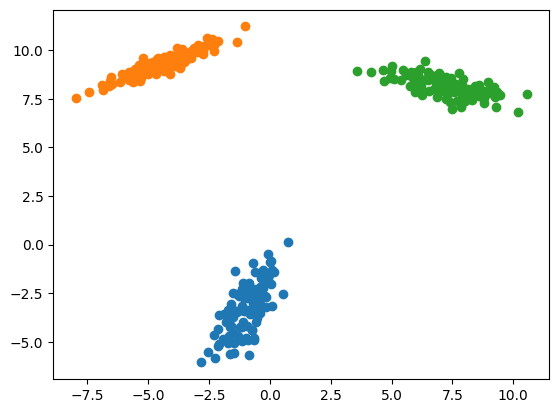

In [3]:


samples = vgmm.sample_from_each_gaussian(B = 100) # N, B, D
n = vgmm.n_components
for i in range(n):
    plt.scatter(samples[i,:,0], samples[i,:,1])

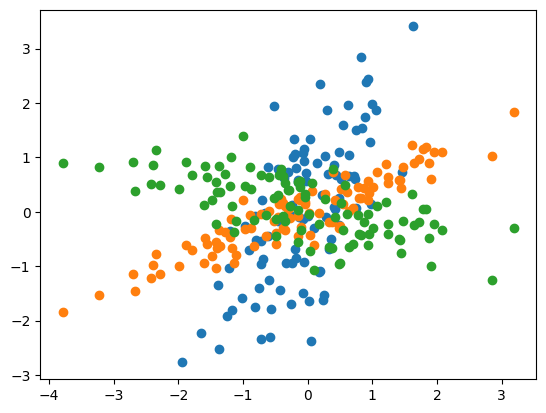

In [4]:

centered = (samples - vgmm.means[:,None])
for i in range(n):
    plt.scatter(centered[i,:,0], centered[i,:,1])


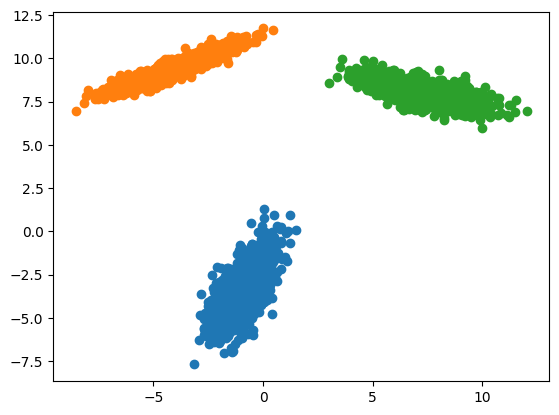

In [5]:
from einops import rearrange

B= 1000
samples = vgmm.sample_from_each_gaussian(B = B)
samples_flat = rearrange(samples, "n b d -> (n b) d")
for i in range(vgmm.n_components):
    plt.scatter(samples_flat[i*B:(i+1)*B,0], samples_flat[i*B:(i+1)*B,1])

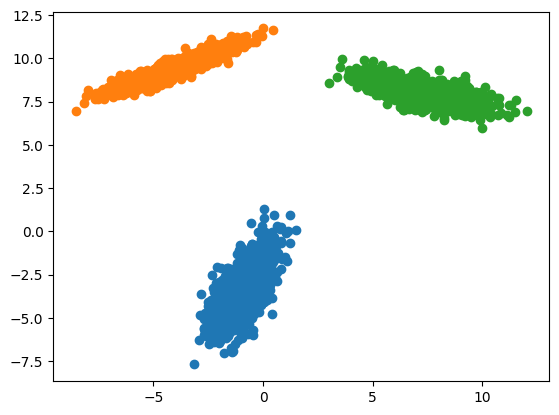

In [6]:
samples_rerearrange = rearrange(samples_flat, "(n b) d -> n b d", b = B)
for i in range(vgmm.n_components):
    plt.scatter(samples_rerearrange[i,:,0], samples_rerearrange[i,:,1])

In [7]:
 def compute_grads_full(self, target, noise = None, B = 1, optim_epsilon = True):

        samples = self.sample_from_each_gaussian(noise = noise, B = B) # n, b, d

        samples_flat = rearrange(samples, "n b d -> (n b) d")

        grad_log_vgmm = self.gradient_log_density(samples_flat)
        grad_log_pi = target.gradient_log_density(samples_flat)
     
        centered_samples = samples - self.means[:,None] ### n, b, d


        # print(grad_log_pi.shape)
        # print(grad_log_vgmm.shape)

        grad_log_pi = rearrange(grad_log_pi , "(n b) d -> n b d", b = B)
        grad_log_vgmm = rearrange(grad_log_vgmm , "(n b) d -> n b d", b = B)

        grad_means = (grad_log_vgmm - grad_log_pi).mean(axis = 1)/self.n_components


        if optim_epsilon:  ## TODO grad covs

            E_grad_log_pi_centered_s = (grad_log_pi*centered_samples).sum(axis = -1).mean(axis = -1) ### dot product and mean, sum over dimension, mean over batch
            E_grad_log_vgmm_centered_s = (grad_log_vgmm*centered_samples).sum(axis = -1).mean(axis = -1) ### dot product and mean, sum over dimension, mean over batch 

            grad_epsilons = (E_grad_log_vgmm_centered_s - E_grad_log_pi_centered_s)/(2*self.n_components*self.epsilons) ### n, b
            
        else:
            grad_epsilons = None

        return grad_means, grad_epsilons

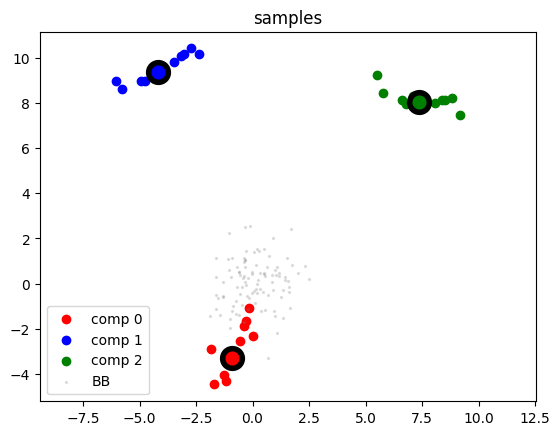

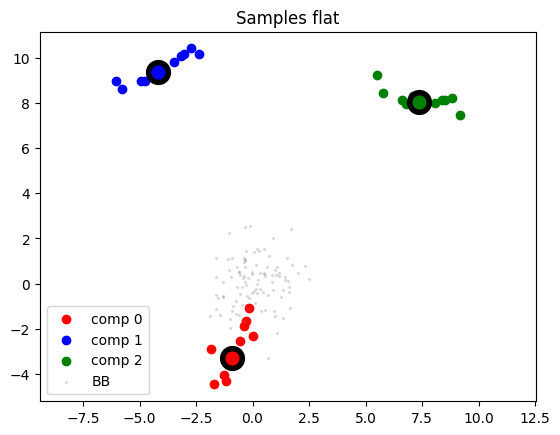

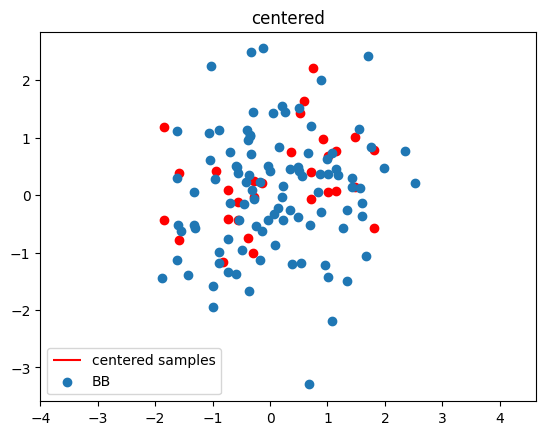

c normal que ca se superpose puisque c un bb transformé pour chaque compo


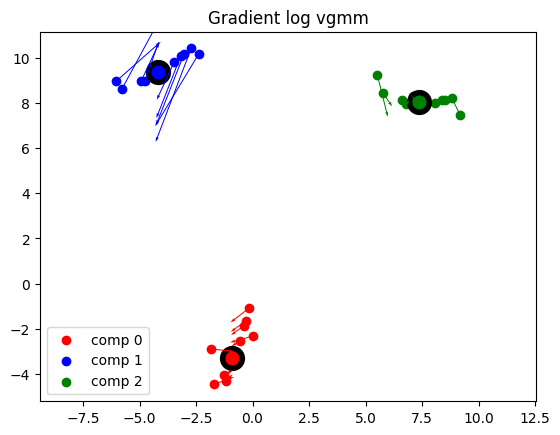

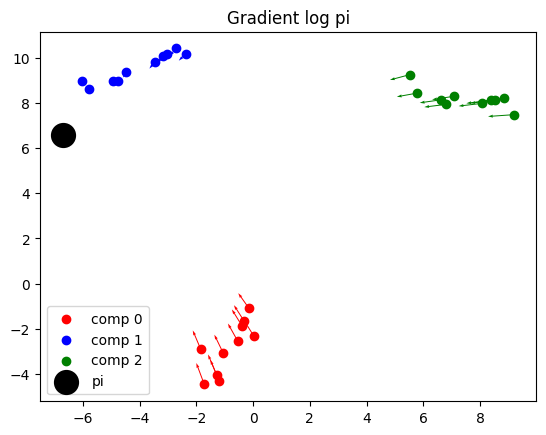

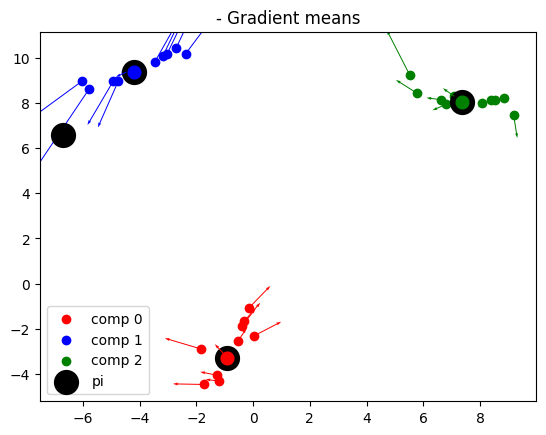

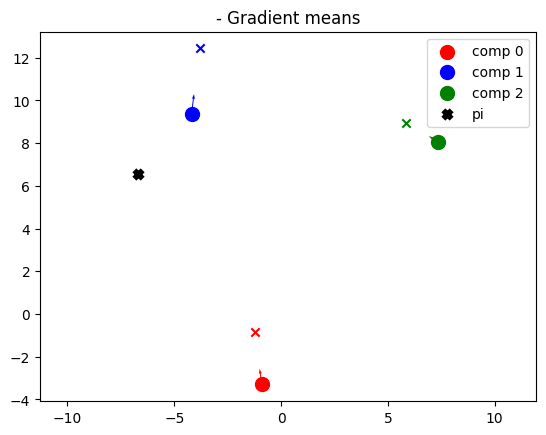

In [8]:
from einops import rearrange


from src_bis.optim import VI_IGMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import IGMM
import numpy as np 

d = 2
target = Target("gmm",mode = "diag", n_components=1, s = np.sqrt(d) * 5, scale = np.sqrt(d)*10,  d = d)



samples = vgmm.sample_from_each_gaussian(B = 10) # n b d 
BB = np.random.randn(100, 2)

n , b, d = samples.shape
colors  =  ["red", "blue", "green"]
for i in range(n):
    plt.scatter(samples[i,:,0], samples[i,:,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vgmm.means[i,0],vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )

plt.axis("equal")
plt.scatter(BB[:,0], BB[:,1], label  = "BB", color = "gray", alpha = 0.2, s = 2)

plt.legend()
plt.title("samples")
plt.show()

samples_flat = rearrange(samples, "n b d -> (n b) d")
for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vgmm.means[i,0],vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
plt.scatter(BB[:,0], BB[:,1], label  = "BB", color = "gray", alpha = 0.2, s = 2)

plt.legend()
plt.title("Samples flat")
plt.axis("equal")
plt.show()

centered_samples = samples - vgmm.means[:,None] ### n,b,d

for i in range(n):
    plt.scatter(centered_samples[i,:,0], centered_samples[i,:,1], color = colors[0])
plt.vlines(0,0,0, colors = "red",  label = "centered samples")
plt.scatter(BB[:,0], BB[:,1], label  = "BB")
plt.legend()
plt.axis("equal")

plt.title("centered")
plt.show()

print("c normal que ca se superpose puisque c un bb transformé pour chaque compo")

grad_log_vgmm = vgmm.gradient_log_density(samples_flat)
grad_log_pi = target.model.gradient_log_density(samples_flat)

grad_log_pi = rearrange(grad_log_pi , "(n b) d -> n b d", b = b)
grad_log_vgmm = rearrange(grad_log_vgmm , "(n b) d -> n b d", b = b)
coef = 3

for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vgmm.means[i,0],vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
    plt.quiver(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], grad_log_vgmm[i,:, 0]*coef, grad_log_vgmm[i, :, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)
plt.legend()
plt.title("Gradient log vgmm")
plt.axis("equal")

plt.show()

coef = 8
for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    # plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
    plt.quiver(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], grad_log_pi[i,:, 0]*coef, grad_log_pi[i, :, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)

plt.scatter(target.model.means[:,0],target.model.means[:,1] ,  s=200,color = "black", linewidths=4 , label = "pi")
plt.legend()
plt.title("Gradient log pi")
# plt.axis("equal")

plt.show()

coef = 10
grad_means  = (grad_log_vgmm - grad_log_pi)/n
for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vgmm.means[i,0],vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
    plt.quiver(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1],-grad_means[i,:, 0]*coef, -grad_means[i, :, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)

plt.scatter(target.model.means[:,0],target.model.means[:,1] ,  s=200,color = "black", linewidths=4 , label = "pi")
plt.legend()
plt.title("- Gradient means")
plt.show()

coef = 15
grad_means = grad_means.mean(axis = 1)

for i in range(n):
    plt.scatter(vgmm.means[i,0],vgmm.means[i,1] ,  color=colors[i] , label = f"comp {i}", s = 100)
    plt.quiver(vgmm.means[i,0], vgmm.means[i,1], - grad_means[i, 0]*coef, - grad_means[i, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)



lr =5
new_means = vgmm.means - lr * grad_means
for i in range(n):
    plt.scatter(new_means[i,0],new_means[i,1] ,  color=colors[i] , marker = "x")
plt.axis("equal")
    
plt.scatter(target.model.means[:,0],target.model.means[:,1] ,color = "black", linewidths=4 , label = "pi",  marker = "x")

plt.legend()
plt.title("- Gradient means")
plt.show()




<Axes: >

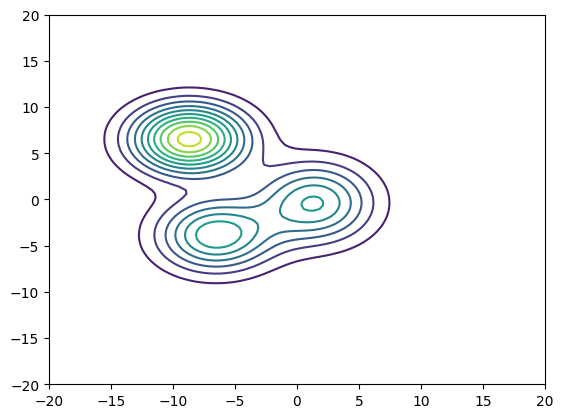

In [95]:

from src_bis.optim import VI_GMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import FGMM


target = Target("gmm", "diag", n_components=3, s = 10, scale = 10,  d = 2)
target.plot()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 34/10000 [00:00<00:58, 171.01it/s]

LR 0.5
KL  8.661028205537626


 10%|█         | 1029/10000 [00:06<00:50, 178.58it/s]

LR 0.5
KL  0.00648809887034897


 20%|██        | 2018/10000 [00:12<00:48, 165.93it/s]

LR 0.5
KL  0.0025535351006743968


 30%|███       | 3032/10000 [00:18<00:41, 167.92it/s]

LR 0.5
KL  0.0012116809486431865


 40%|████      | 4029/10000 [00:24<00:29, 199.41it/s]

LR 0.5
KL  0.0006391167025163993


 50%|█████     | 5028/10000 [00:29<00:24, 205.44it/s]

LR 0.5
KL  0.0003460383687194808


 60%|██████    | 6036/10000 [00:34<00:21, 185.56it/s]

LR 0.5
KL  0.00017747635532883876


 70%|███████   | 7028/10000 [00:39<00:14, 200.35it/s]

LR 0.5
KL  1.4788342322559877e-05


 80%|████████  | 8035/10000 [00:45<00:09, 201.48it/s]

LR 0.5
KL  -4.1118822824836696e-05


 90%|█████████ | 9033/10000 [00:51<00:06, 158.09it/s]

LR 0.5
KL  -7.723985887725072e-05


100%|██████████| 10000/10000 [00:57<00:00, 175.18it/s]


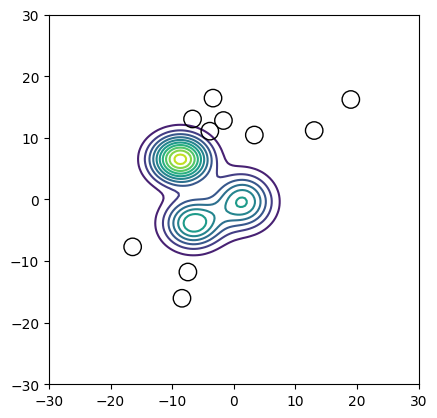

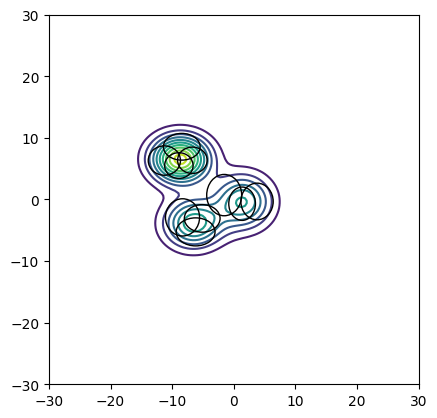

In [120]:
vi_full = VI_GMM(target, mode = "full", learning_rate=0.5, n_iterations=10000, n_components = 10, scale = 2, BG = 100, s = 20) 
vi_full.optimize(bw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True) 

ax = target.plot()
vi_full.vgmm.plot_circle(0, ax,bound = 30)
plt.show()
ax = target.plot()
vi_full.vgmm.plot_circle(-1, ax,bound = 30)




  0%|          | 43/10000 [00:00<00:46, 214.12it/s]

LR 0.5
KL  8.652690722488149


 10%|█         | 1034/10000 [00:04<00:38, 231.42it/s]

LR 0.5
KL  0.0018038456852369454


 20%|██        | 2028/10000 [00:09<00:35, 223.13it/s]

LR 0.5
KL  0.0007282344415673609


 30%|███       | 3039/10000 [00:14<00:30, 231.82it/s]

LR 0.5
KL  0.00034302420474058157


 40%|████      | 4046/10000 [00:18<00:25, 235.49it/s]

LR 0.5
KL  1.768132632810637e-05


 50%|█████     | 5029/10000 [00:23<00:33, 148.44it/s]

LR 0.5
KL  -0.00017644554299319103


 60%|██████    | 6024/10000 [00:27<00:18, 218.31it/s]

LR 0.5
KL  -0.0004217341677908255


 70%|███████   | 7026/10000 [00:32<00:12, 230.99it/s]

LR 0.5
KL  -0.0005846593190325952


 80%|████████  | 8019/10000 [00:37<00:11, 175.81it/s]

LR 0.5
KL  -0.0007231212302324446


 90%|█████████ | 9040/10000 [00:42<00:04, 223.55it/s]

LR 0.5
KL  -0.0008581712836957997


100%|██████████| 10000/10000 [00:46<00:00, 214.14it/s]


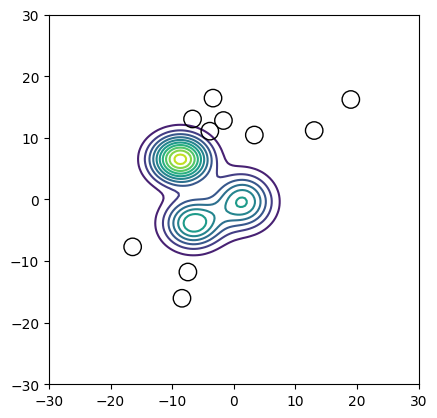

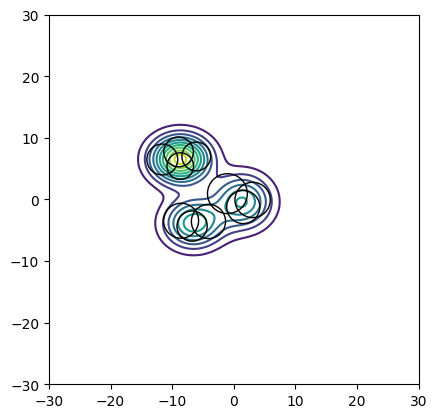

In [126]:
vi_iso = VI_GMM(target, mode = "iso", learning_rate=0.5, n_iterations=10000, n_components = 10, scale = 2, BG = 100, s = 20, means = vi_full.vgmm.optimized_means[0]) 
vi_iso.optimize(bw = True, md  = False, lin = False, means_only=False, plot_iter=1000, gen_noise=True) 

ax = target.plot()
vi_iso.vgmm.plot_circle(0, ax,bound = 30)
plt.show()
ax = target.plot()
vi_iso.vgmm.plot_circle(-1, ax,bound = 30)

  0%|          | 39/10000 [00:00<00:51, 194.11it/s]

LR 0.5
KL  8.610076240546578


 10%|█         | 1015/10000 [00:05<00:50, 176.23it/s]

LR 0.5
KL  0.00036975144451975074


 20%|██        | 2031/10000 [00:11<00:47, 169.05it/s]

LR 0.5
KL  -1.3771166584869653e-05


 30%|███       | 3015/10000 [00:16<00:37, 188.22it/s]

LR 0.5
KL  0.00014587946878338086


 40%|████      | 4027/10000 [00:21<00:35, 166.43it/s]

LR 0.5
KL  0.00016081574990048077


 50%|█████     | 5030/10000 [00:27<00:22, 224.00it/s]

LR 0.5
KL  0.00020493574556115134


 60%|██████    | 6021/10000 [00:32<00:31, 126.29it/s]

LR 0.5
KL  0.00026847800843743743


 70%|███████   | 7033/10000 [00:37<00:14, 210.48it/s]

LR 0.5
KL  0.0003142522836862538


 80%|████████  | 8024/10000 [00:42<00:09, 209.56it/s]

LR 0.5
KL  0.00040906001342400967


 90%|█████████ | 9017/10000 [00:50<00:05, 183.68it/s]

LR 0.5
KL  0.0004692115292643191


100%|██████████| 10000/10000 [00:55<00:00, 180.69it/s]


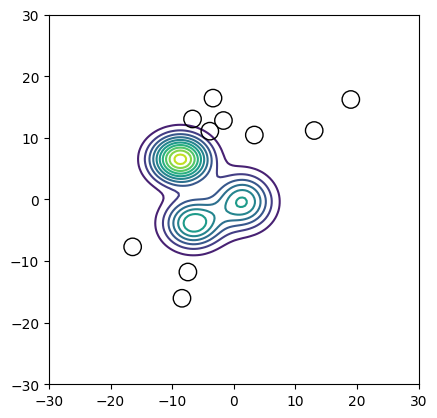

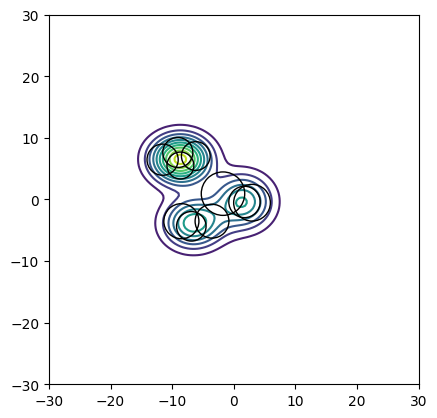

In [127]:
vi_lin = VI_GMM(target, mode = "iso", learning_rate=0.5, n_iterations=10000, n_components = 10, scale = 2, BG = 100, s = 20, means = vi_full.vgmm.optimized_means[0]) 
vi_lin.optimize(bw = False, md  = False, lin = True,  means_only=False, plot_iter=1000, gen_noise=True) 

ax = target.plot()
vi_lin.vgmm.plot_circle(0, ax,bound = 30)
plt.show()
ax = target.plot()
vi_lin.vgmm.plot_circle(-1, ax,bound = 30)

  0%|          | 37/10000 [00:00<00:53, 187.89it/s]

LR 0.5
KL  9.608063775948679


 10%|█         | 1029/10000 [00:04<00:38, 231.82it/s]

LR 0.5
KL  0.013530762526244711


 20%|██        | 2023/10000 [00:09<00:39, 202.46it/s]

LR 0.5
KL  0.007984462430938753


 30%|███       | 3035/10000 [00:14<00:36, 192.42it/s]

LR 0.5
KL  0.006127528118638216


 40%|████      | 4037/10000 [00:20<00:41, 143.08it/s]

LR 0.5
KL  0.005081878280443833


 50%|█████     | 5028/10000 [00:25<00:22, 224.03it/s]

LR 0.5
KL  0.004392027180721733


 60%|██████    | 6019/10000 [00:30<00:27, 144.45it/s]

LR 0.5
KL  0.0038842611855837922


 70%|███████   | 7043/10000 [00:35<00:14, 206.64it/s]

LR 0.5
KL  0.0034959853480480544


 80%|████████  | 8031/10000 [00:41<00:10, 186.63it/s]

LR 0.5
KL  0.0032119396187218017


 90%|█████████ | 9038/10000 [00:47<00:05, 180.06it/s]

LR 0.5
KL  0.0029975056876726997


100%|██████████| 10000/10000 [00:52<00:00, 191.56it/s]


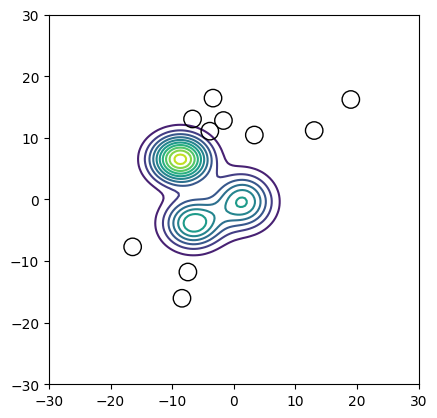

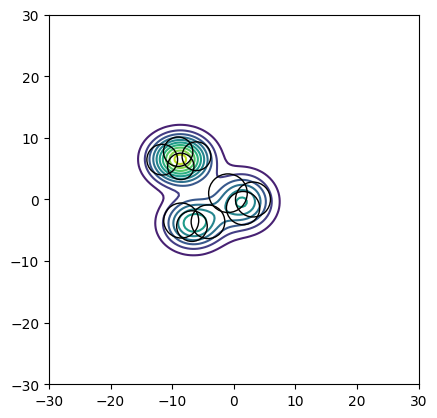

In [128]:
vi_md = VI_GMM(target, mode = "iso", learning_rate=0.5, n_iterations=10000, n_components = 10, scale = 2, BG = 100, s = 20, means = vi_full.vgmm.optimized_means[0]) 
vi_md.optimize(bw = False, md  = True, lin = False,  means_only=False, plot_iter=1000, gen_noise=True) 

ax = target.plot()
vi_md.vgmm.plot_circle(0, ax,bound = 30)
plt.show()
ax = target.plot()
vi_md.vgmm.plot_circle(-1, ax,bound = 30)

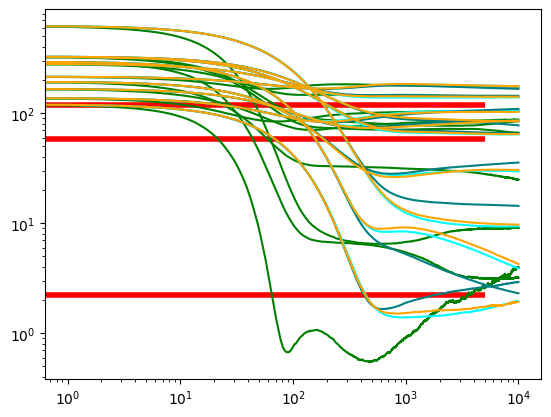

In [133]:
plt.hlines((vi_full.target.model.means**2).sum(axis = -1), 0, 5000, color = "red", lw = 4)
plt.loglog((vi_lin.vgmm.get_means_evolution()**2).sum(axis = -1), color = "green")
plt.loglog((vi_iso.vgmm.get_means_evolution()**2).sum(axis = -1),  color = "cyan")
plt.loglog((vi_full.vgmm.get_means_evolution()**2).sum(axis = -1),  color = "teal")
plt.loglog((vi_md.vgmm.get_means_evolution()**2).sum(axis = -1),  color = "orange")


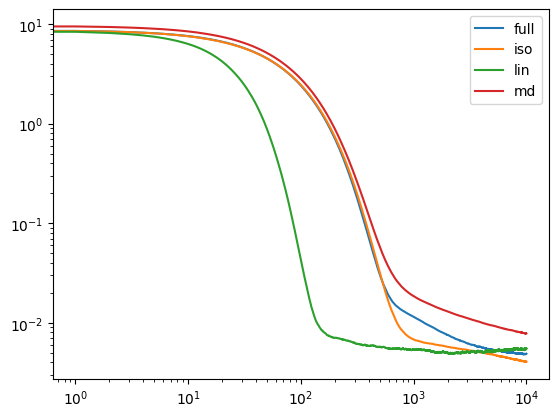

In [ ]:
z = 0.005
plt.loglog(np.array(vi_full.kls)+z, label = "full")
plt.loglog(np.array(vi_iso.kls)+z, label = "iso")
plt.loglog(np.array(vi_lin.kls)+z, label = "lin")
plt.loglog(np.array(vi_md.kls)+z, label = "md")
plt.ylim()
plt.legend()

# Funnel

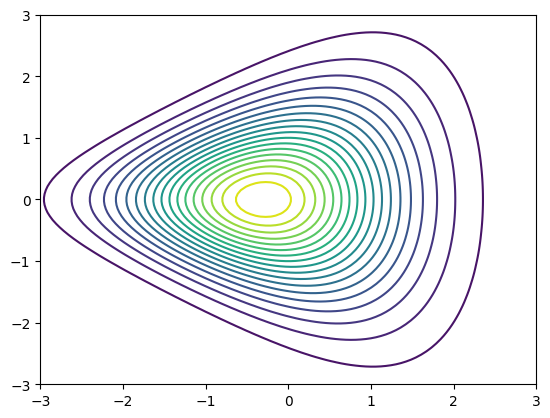

In [128]:
from scipy.stats import multivariate_normal 
import torch
from torch.distributions import MultivariateNormal
from einops import rearrange 
import numpy as np 

grid_size = 100
bound = 3
x1 = np.linspace(-bound,bound, grid_size)
x2 = np.linspace(-bound,bound, grid_size)
x1, x2 = np.meshgrid(x1,x2)
x = np.dstack((x1, x2))
x = rearrange(x, "h w d -> (h w) d")


means = (0,0)
sigma = 1.2



g1 = multivariate_normal(means[0], sigma)

b = x.shape[0]

means_tensor = torch.full((b, 1), means[0])
cov_tensor = torch.exp(torch.as_tensor(x[:, 0])/2).unsqueeze(-1).unsqueeze(-1)  # shape becomes (b, 1, 1)
g2 = MultivariateNormal(means_tensor, covariance_matrix=cov_tensor)
density = rearrange(g1.pdf(x[:, 0])*g2.log_prob(torch.as_tensor(x[:, 1][:, None])).exp().numpy(), "(h w) -> h w ", h = grid_size)
          
fig, ax = plt.subplots()
ax.contour(x1, x2, density, levels=20, cmap="viridis")


In [149]:
from scipy.stats import multivariate_normal 


class Funnel:
    def __init__(self, means = (0,0),  sigma = 1.2):
        self.sigma = sigma
        self.means = means
        self.dim = 2
        self.g1 = multivariate_normal(means[0], sigma)
        

    def prob(self, x):
        ### x size b 2 = d

        b = x.shape[0]

        means_tensor = torch.full((b, 1), self.means[1])
        cov_tensor = torch.exp(torch.as_tensor(x[:, 0])/2).unsqueeze(-1).unsqueeze(-1)  # shape becomes (b, 1, 1)
        g2 = MultivariateNormal(means_tensor, covariance_matrix=cov_tensor)
        return  self.g1.pdf(x[:, 0])*g2.log_prob(torch.as_tensor(x[:, 1][:, None])).exp().numpy()          
    
    def log_prob(self, x):
        return self.prob(x).log()
    
    def gradient_log_density(self, x):
        ### grad first variable 
        grad1 = - x[:,0]/self.sigma - 0.25 + ((x[:, 1]**2)/(2* np.exp(x[:, 0])))
        grad2 =  - x[:, 1]/np.exp(x[:, 0])

        return np.stack((grad1, grad2)).T

        
        

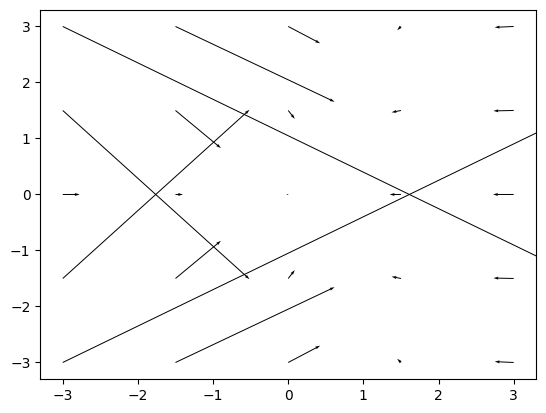

In [148]:
target  = Funnel()

grid_size = 5
bound = 3
x1 = np.linspace(-bound,bound, grid_size)
x2 = np.linspace(-bound,bound, grid_size)
x1, x2 = np.meshgrid(x1,x2)
x = np.dstack((x1, x2))
x = rearrange(x, "h w d -> (h w) d")

density = target.prob(x)
grad = target.gradient_log_density(x)

coef = 1
plt.quiver(x[:,0], x[:, 1], grad[:, 0]*coef, grad[:, 1]*coef, 
        angles="xy", scale_units="xy", scale=10, alpha=1, width=0.002)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 18/5000 [00:00<00:53, 93.11it/s]

LR 0.1
KL  3.7850432655011463


 20%|██        | 1023/5000 [00:08<00:33, 119.42it/s]

LR 0.1
KL  0.3676380178865907


 41%|████      | 2028/5000 [00:16<00:22, 133.69it/s]

LR 0.1
KL  0.1847259238635092


 60%|██████    | 3013/5000 [00:25<00:14, 134.21it/s]

LR 0.1
KL  0.15010520905989103


 80%|████████  | 4021/5000 [00:36<00:07, 129.52it/s]

LR 0.1
KL  0.13911835823156346


100%|██████████| 5000/5000 [00:44<00:00, 112.81it/s]


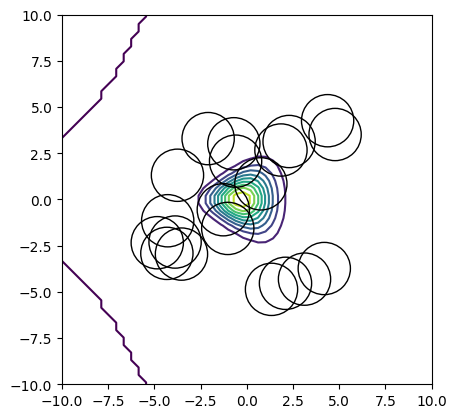

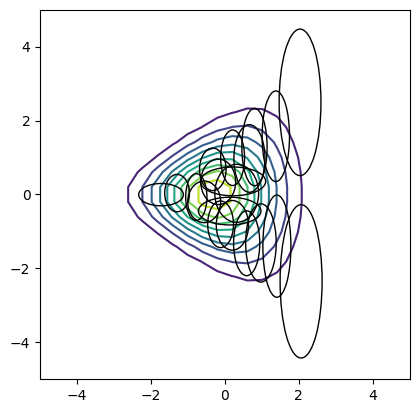

<Axes: >

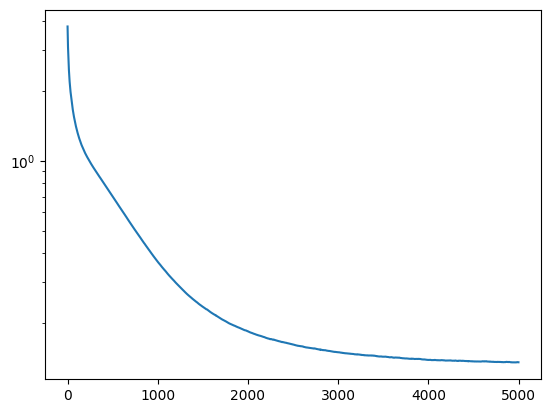

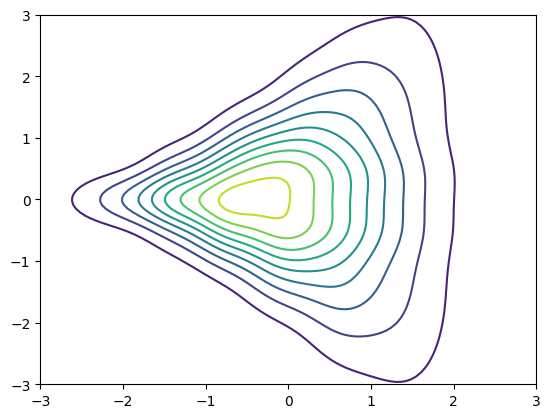

In [90]:

from src_bis.optim import VI_GMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import FGMM


target = Target("funnel")

vi_full = VI_GMM(target, mode = "full", learning_rate=0.1, n_iterations=5000, n_components = 20, scale = 2, BG = 100, s = 5) 
vi_full.optimize(bw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True) 

ax = target.plot()
vi_full.vgmm.plot_circle(0, ax,bound = 10)
plt.show()
ax = target.plot()
vi_full.vgmm.plot_circle(-1, ax,bound = 5)
plt.show()
vi_full.plot_estimated()

plt.semilogy(vi_full.kls)


vi_full.vgmm.contours = None
vi_full.vgmm.plot_estimated(bound = 3)



  0%|          | 10/5000 [00:00<00:54, 91.07it/s]

LR 0.1
KL  4.013097394905256


 21%|██        | 1027/5000 [00:06<00:23, 170.80it/s]

LR 0.1
KL  0.23541944730163192


 41%|████      | 2027/5000 [00:12<00:20, 142.76it/s]

LR 0.1
KL  0.11538211919648908


 60%|██████    | 3012/5000 [00:22<00:35, 55.57it/s] 

LR 0.1
KL  0.09687961847545455


 80%|████████  | 4016/5000 [00:32<00:07, 137.78it/s]

LR 0.1
KL  0.09294341025391335


100%|██████████| 5000/5000 [00:40<00:00, 122.26it/s]


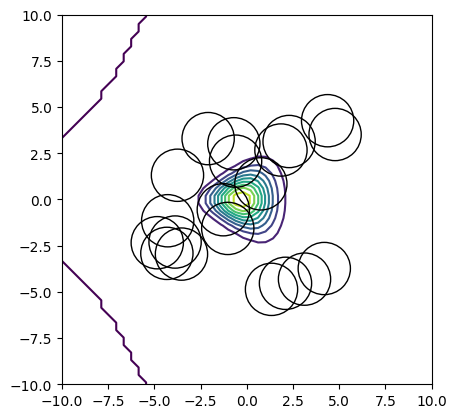

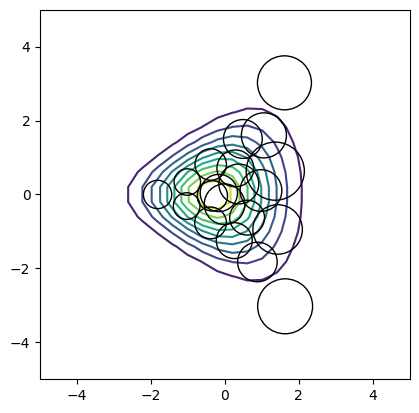

<Axes: >

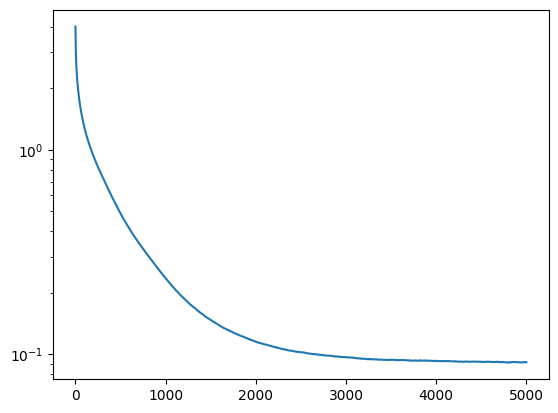

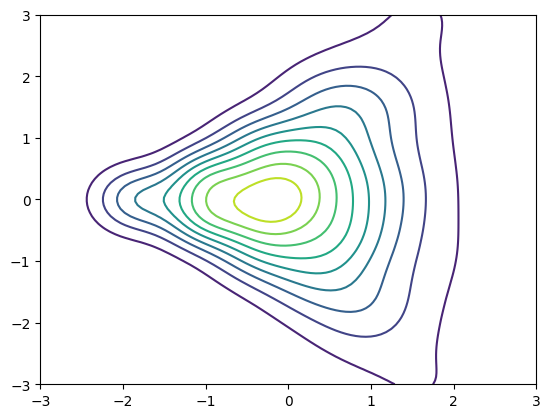

In [91]:

from src_bis.optim import VI_GMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import FGMM



vi_iso = VI_GMM(target, mode = "iso", learning_rate=0.1, n_iterations=5000, n_components = 20, scale = 2, BG = 100, s = 10, means = vi_full.vgmm.optimized_means[0]) 
vi_iso.optimize(bw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True) 

ax = target.plot()
vi_iso.vgmm.plot_circle(0, ax,bound = 10)
plt.show()
ax = target.plot()
vi_iso.vgmm.plot_circle(-1, ax,bound = 5)
plt.show()
vi_iso.plot_estimated()

plt.semilogy(vi_iso.kls)


vi_iso.vgmm.contours = None
vi_iso.vgmm.plot_estimated(bound = 3)




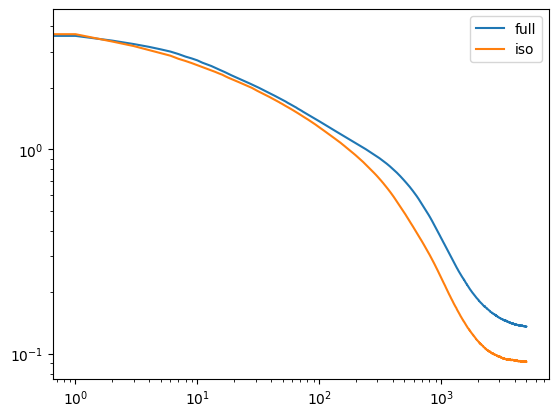

In [92]:
plt.loglog(vi_full.kls, label = "full")
plt.loglog(vi_iso.kls, label = "iso")
plt.legend()

ISOTROPIC


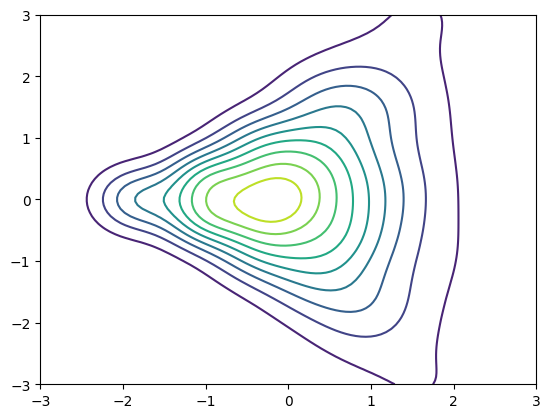

FULL


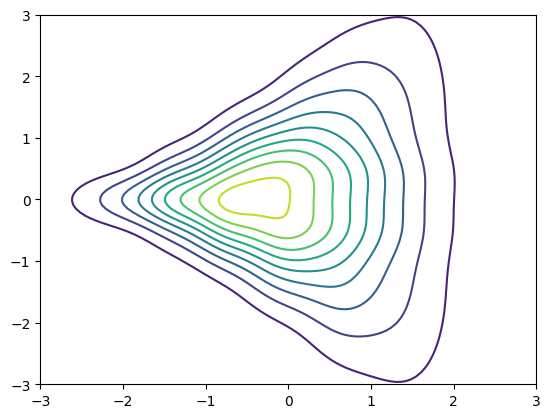

TARGET


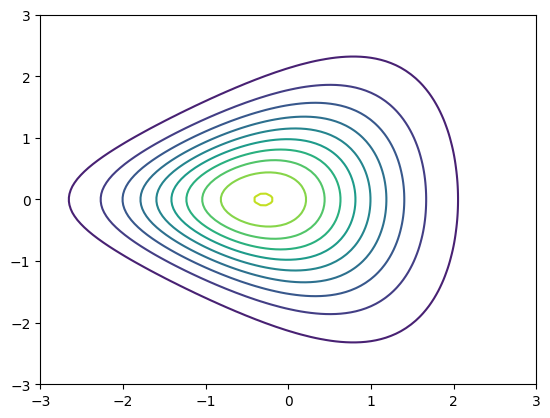

In [94]:
print("ISOTROPIC")
vi_iso.vgmm.plot_estimated(bound = 3)
plt.show()
print("FULL")
vi_full.vgmm.plot_estimated(bound = 3)

plt.show()
print("TARGET")
target.contours = None
ax = target.plot(bound = 3)



# Lin updates

In [100]:
(vi_iso.vgmm.epsilons)**(-1)

array([1.80983752, 7.6920885 , 6.80120085, 3.31664936, 5.53182969,
       1.87544774, 2.69033712, 5.42936792, 3.42921886, 4.02341414,
       4.50475272, 7.79609669, 1.61571284, 3.62883775, 3.13728394,
       4.23619402, 3.48626944, 5.94134381, 3.93324099, 2.2290971 ])